# Comparing ANHA4 d18O with Obs

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
#sys.setdefaultencoding('utf8')
sys.path.insert(0, '_libs/')

In [4]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, cm
% matplotlib inline

In [5]:
from NEMO_tools import int_profile, bin_profile, find_inland, reporj_NEMOgrid

In [6]:
# nonlinear colormap, borrowed from Robert Hetland <hetland@tamu.edu>, under MIT license.
# http://protracted-matter.blogspot.ca/2012/08/nonlinear-colormap-in-matplotlib.html
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    name = 'nlcmap'    
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels / self.levels.max()
        self._y = np.linspace(0.0, 1.0, len(self.levels))
    def __call__(self, xi, alpha=1.0, **kw):
        """docstring for fname"""
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

# Get the data ready

In [7]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/BGEP_d18O.mat')
x03 = MAT['d18O2003'][:, 1]; y03 = MAT['d18O2003'][:, 0]; z03 = MAT['d18O2003'][:, 2]; d18O03 = MAT['d18O2003'][:, 3]
x04 = MAT['d18O2004'][:, 1]; y04 = MAT['d18O2004'][:, 0]; z04 = MAT['d18O2004'][:, 2]; d18O04 = MAT['d18O2004'][:, 3]
x04[d18O04<0]=np.nan; y04[d18O04<0]=np.nan; z04[d18O04<0]=np.nan; d18O04[d18O04<0]=np.nan
x05 = MAT['d18O2005'][:, 1]; y05 = MAT['d18O2005'][:, 0]; z05 = MAT['d18O2005'][:, 2]; d18O05 = MAT['d18O2005'][:, 3]

In [8]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/HLY_d18O.mat')
xH = np.squeeze(MAT['lon'][:]); yH = np.squeeze(MAT['lat'][:]); zH = np.squeeze(MAT['dep'][:]); d18OH = np.squeeze(MAT['d18O'][:])

In [9]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/CBL_d18O.mat')
xC = np.squeeze(MAT['lon'][:]); yC = np.squeeze(MAT['lat'][:]); zC = np.squeeze(MAT['dep'][:]); d18OC = np.squeeze(MAT['d18O'][:])

In [14]:
x_all = np.hstack((x03, x04, x05, xH, xC))
y_all = np.hstack((y03, y04, y05, yH, yC))
z_all = np.hstack((z03, z04, z05, zH, zC))
d18O_all = np.hstack((d18O03, d18O04, d18O05, d18OH, d18OC))

In [15]:
ANHA4_MAT=scipy.io.loadmat('_data/Exchange/coord_ANHA4.mat')
deptht = ANHA4_MAT['nav_lev'][:]

In [16]:
tar_dep = 5250
dep_surf = deptht[deptht<tar_dep]

x_surf = x_all[z_all<tar_dep]
y_surf = y_all[z_all<tar_dep]
z_surf = z_all[z_all<tar_dep]
d18O_surf = d18O_all[z_all<tar_dep]

In [18]:
intx, inty, out_surf = int_profile(x_surf, y_surf, z_surf, d18O_surf, dep_surf, thres=2000)

In [22]:
year = np.array([200308, 200408, 200508, 200308, 200209])
time_ind = np.array([8, 19, 31, 42])
proxy_d18O = [1, 2, 3, 1, 0]
time_limit = np.array([223, 223+397, 223+397+302, 223+397+302+566, 223+397+302+566+971])-1

# Get the model output ready

In [23]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/SPIN06_SET02_1m_20020101_20131231_ptrc_T.nc'

In [24]:
ptrc_obj = nc.Dataset(FName)
Ba = np.squeeze(ptrc_obj.variables['Ba'][time_ind, :, :, :]) #67
d18O = np.squeeze(ptrc_obj.variables['d18O'][time_ind, :, :, :])
d18O[Ba==0]=np.nan
nav_lat = ptrc_obj.variables['nav_lat'][:]
nav_lon = ptrc_obj.variables['nav_lon'][:]
deptht = ptrc_obj.variables['deptht'][:]

In [25]:
#x = x05[z05<900]
#y = y05[z05<900]
#d18O_sample = d18O05[z05<900]
#d = z05[z05<900]

In [26]:
locx, locy = Nts.nearest_search(nav_lon, nav_lat, intx, inty)

#Comparisons

In [89]:
def unique_continue(x):
    # Has the functionality of numpy.unique but work with "repeated and continued" elements    
    A = np.diff(x)
    head = [0]
    counts = []
    sub_counts = 1
    for i in range(len(A)):
        if A[i] == 0:
            sub_counts += 1
        else:
            counts.insert(len(counts), sub_counts)            
            sub_counts = 1
            head.insert(len(counts), i)
        # deal with the end of an array
        if i == len(A)-1:
            counts.insert(len(counts), sub_counts)            
            sub_counts = 1
            head.insert(len(counts), i)
    return np.array(head), np.array(counts)

In [90]:
head_loc, counts_loc = unique_continue(locx*locy)
head_loc[1:]=head_loc[1:]+1

In [91]:
len(head_loc)-1

213

In [92]:
d18O_model = np.zeros([213, 48])
d18O_model[d18O_model==0]=np.nan
for i in range(213):    
    t_loc = np.searchsorted(time_limit, head_loc[i])
    d18O_t = d18O[proxy_d18O[t_loc], :, :, :]
    d18O_model[i, :] = d18O_t[0:-2, locx[i], locy[i]]

In [93]:
d18O_model.shape

(213, 48)

In [114]:
d18O_sample = out_surf[0:213, :].flatten()
d18O_model = d18O_model.flatten()
d18O_sample = d18O_sample[~np.isnan(d18O_sample)]
d18O_model = d18O_model[~np.isnan(d18O_sample)]
d18O_model = d18O_sample+np.random.normal(-0.3,0.5,4233)

In [115]:
d18O_model.shape

(4233,)

In [116]:
# create bins for channel-31 
model_bins = 150
model_lim=[-5, 2]
model_bins=np.linspace(model_lim[0], model_lim[1], model_bins, dtype=np.float)
# and channel-1
sample_bins = 150
sample_lim=[-5, 2]
sample_bins=np.linspace(sample_lim[0], sample_lim[1], sample_bins, dtype=np.float)

In [117]:
y=d18O_model; y_bins=model_bins # x: C31
x=d18O_sample; x_bins=sample_bins # y: C1
H, y_edges, x_edges = np.histogram2d(y, x, bins=(y_bins, x_bins))
X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])

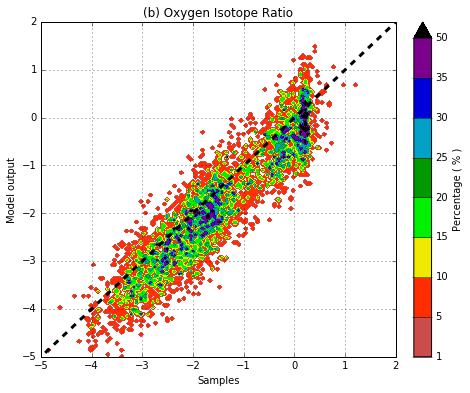

In [120]:
# make_axes_locatable ---> for axis control
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(7, 6))
axMain = fig.gca(); axMain.grid()
clevs=[1, 5, 10, 15, 20, 25, 30, 35, 50]
CMap = nlcmap(plt.cm.nipy_spectral_r, clevs)
xlim_bin=[-5, 2]
ylim_bin=[-5, 2]
axMain.set_xlim(xlim_bin)
axMain.set_ylim(ylim_bin)
axMain.set_xlabel('Samples')
axMain.set_ylabel('Model output')
axMain.set_title('(b) Oxygen Isotope Ratio')
divider=make_axes_locatable(axMain)
CS=axMain.contourf(X, Y, H/np.max(H)*100, clevs, cmap=CMap, extend='max')
axMain.plot([-10, 10], [-10, 10], 'k--', lw=3)
CAx=divider.append_axes('right', size='5%', pad=0.25)
CBar=plt.colorbar(CS, cax=CAx)
CBar.set_label('Percentage ( % )', fontsize=10)
CBar.ax.tick_params(axis='y', length=20)
fig.savefig('_publish/FIG14_2.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
                bbox_inches='tight', pad_inches=0.1)

In [25]:
lev2 = np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])

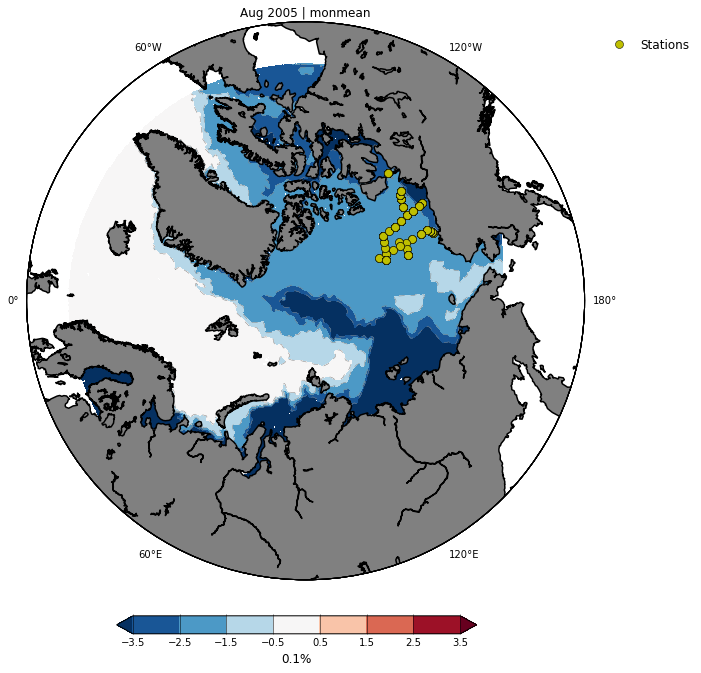

In [28]:
fig=plt.figure(figsize=(10, 10));
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(nav_lon, nav_lat)
CS=proj.contourf(x, y, d18O[-1, 0, :, :], lev2, cmap=plt.cm.RdBu_r, extend='both')
proj.contour(x, y, d18O[-1, 0, :, :], lev2, linewidths=0.5, colors=('gray',))

proj.plot(x[locx, locy], y[locx, locy], 'yo', ms=8, label='Stations')

LG=ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=1, numpoints=1); LG.draw_frame(False)

cax = fig.add_axes([0.25, 0.05, 0.5, 0.025])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('0.1%', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(lev2)

ax.set_title('Aug 2005 | monmean', fontsize=12)
